This notebook is for further investigation of the Potts model in predicting protein fitness with MSA. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy

In [3]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True
    
def model_info(c):
    print("Number of sites: ", c.L)
    print("Number of valid sequences: ", c.N_valid)
    print("Number of invalid sequences: ", c.N_invalid)
    print("Number of valid sequences: ", c.N_valid)

def mutant_predictions(c):
    # read the experimental mutational scanning dataset for PABP by Melamed et al., RNA, 2013
    data = pd.read_csv(
        "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
    )

    # predict mutations using our model
    data_pred = tools.predict_mutation_table(
        c, data, "effect_prediction_epistatic"
    )

    # can also add predictions by the corresponding independent model
    c0 = c.to_independent_model()

    data_pred = tools.predict_mutation_table(
        c0, data_pred, "effect_prediction_independent"
    )
    
    print(data_pred.head())
    pred = data_pred['effect_prediction_epistatic']
    pred_ind = data_pred['effect_prediction_independent']
    label = data_pred['linear']
    print('Evmutation spearman: ', scipy.stats.spearmanr(pred, label))
    print('Independent control spearman: ', scipy.stats.spearmanr(pred_ind, label))

def get_mutant_seq(wildtype, pos_upper):
    data = pd.read_csv(
        "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
    )
    mutant, label = data['mutant'].to_numpy(), data['linear'].to_numpy()
    mutant_data = []
    for m in mutant:
        if m == 'wild':
            mutant_data.append(np.asarray(list(wildtype))[pos_upper])
            continue
        original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
        assert wildtype[loc] == original_aa
        mut_seq = np.asarray(list(wildtype[:loc]+mutant_aa+wildtype[loc+1:]))
        mutant_data.append(mut_seq[pos_upper])
    mutant_data = np.asarray(mutant_data)
    return mutant_data, label

# def 

In [4]:
# modify energy computation to enable computing sequences with gap characters
def mod_convert_sequences(sequences, c):
    """
    Converts sequences in string format into internal symbol representation
    according to alphabet of model

    Parameters
    ----------
    sequences : list of str
        List of sequences (must have same length and correspond to
        model states)

    Returns
    -------
    np.array
        Matrix of size len(sequences) x L of sequences converted to
        integer symbols
    """
    seq_lens = list(set(map(len, sequences)))
    if len(seq_lens) != 1:
        raise ValueError("Input sequences have different lengths: " + str(seq_lens))

    L_seq = seq_lens[0]

    S = np.empty((len(sequences), L_seq), dtype=int)

    try:
        for i, s in enumerate(sequences):
            conv = []
            for x in s:
                if x == '-':
                    conv.append(-1)
                else:
                    conv.append(c.alphabet_map[x])
            S[i] = conv
    except KeyError:
        raise ValueError("Invalid symbol in sequence {}: {}".format(i, x))
    return S
    
def mod_hamiltonians(sequences, J_ij, h_i):
    """
    Calculates the Hamiltonian of the global probability distribution P(A_1, ..., A_L)
    for a given sequence A_1,...,A_L from J_ij and h_i parameters

    Parameters
    ----------
    sequences : np.array
        Sequence matrix for which Hamiltonians will be computed
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Float matrix of size len(sequences) x 3, where each row corresponds to the
        1) total Hamiltonian of sequence and the 2) J_ij and 3) h_i sub-sums
    """
    # iterate over sequences
    N, L = sequences.shape
    H = np.zeros((N, 3))
    for s in range(N):
        A = sequences[s]
        hi_sum = 0.0
        Jij_sum = 0.0
        for i in range(L):
            if A[i] != -1:
                hi_sum += h_i[i, A[i]]
                for j in range(i + 1, L):
                    if A[j] != -1:
                        Jij_sum += J_ij[i, j, A[i], A[j]]

        H[s] = [Jij_sum + hi_sum, Jij_sum, hi_sum]

    return H

def energies_from_model(c, sequences):
    S = mod_convert_sequences(sequences.tolist(), c)
    msa_energies = mod_hamiltonians(S, c.J_ij, c.h_i)
    return msa_energies

def valid_weights_from_model(c):
    ### returns only valid weights
    _w = c.weights
    _w_valid = []
    for i in range(c.weights.shape[0]):
        if _w[i] == 0: 
            continue
        _w_valid.append(1/_w[i])
    return _w_valid

def valid_index(c, idx):
    _w = c.weights
    cnt = 0
    assert idx <=_w.shape[0]
    for i in range(idx):
        if _w[i] == 0:
            cnt += 1
    return idx - cnt

In [5]:
NAME = 'PABP_YEAST'

### training code for model, uncomment the following line: 
#!plmc/bin/plmc -o PABP_YEAST/model/{NAME}.model_params -c PABP_YEAST/model/{NAME}.txt -f PABP_YEAST -le 16.2 -lh 0.01 -m 200 -t 0.2 -g PABP_YEAST/data/{NAME}.a2m
c = CouplingsModel("PABP_YEAST/model/PABP_YEAST.model_params")

model_info(c)

w_full_valid = valid_weights_from_model(c)


Number of sites:  82
Number of valid sequences:  151496
Number of invalid sequences:  545
Number of valid sequences:  151496


In [6]:
### Getting the raw string representations of the sequences
### sequence can be invalid for two reasons: 
### 1. Does not pass check_sequence()
### 2. contains 'x'

yeast_seq_str = []
fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
for fasta in fasta_sequences:
    yeast_seq_str.append(str(fasta.seq))
pos_upper = [x for x in range(len(yeast_seq_str[0])) if not yeast_seq_str[0][x].islower()]
processed_yeast = np.asarray([np.asarray(list(s))[pos_upper] for s in yeast_seq_str if not 'x' in s])
processed_yeast = np.asarray([s for s in processed_yeast if check_sequence(s) and len(s)==82])
wildtype = yeast_seq_str[0]
print(processed_yeast.shape)


(151496, 82)


In [7]:
### compute energies obtained from model trained with all sequences
msa_energies = energies_from_model(c, processed_yeast)

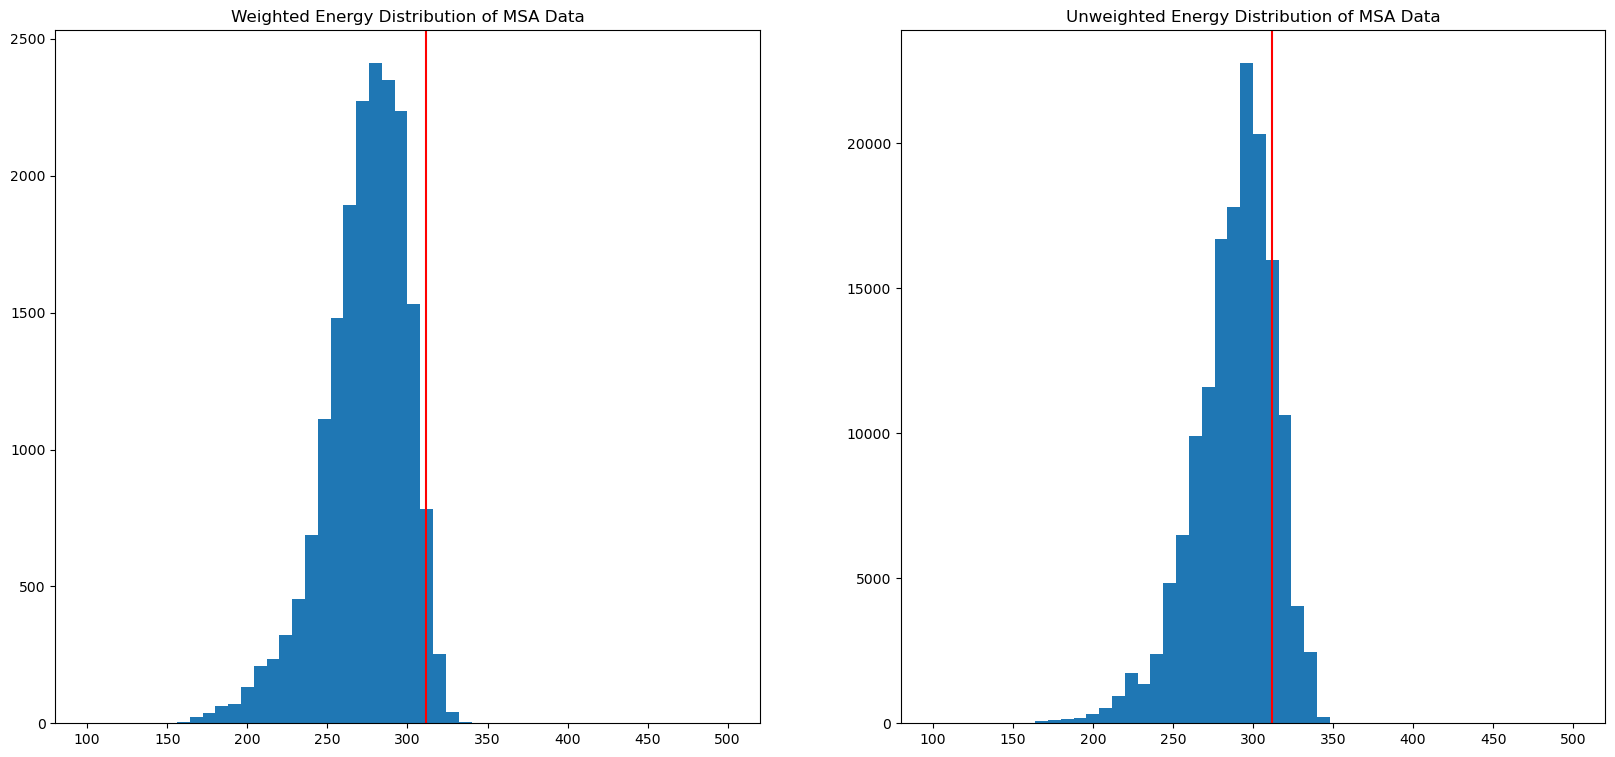

In [8]:
plt.figure(figsize=(20, 9))
plt.subplot(1, 2, 1)
plt.hist(msa_energies[:, 0], weights=w_full_valid, bins=50, range=(100, 500))

plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red') # energy of wildtype
plt.title("Weighted Energy Distribution of MSA Data")

plt.subplot(1, 2, 2)
plt.hist(msa_energies[:, 0], bins=50, range=(100, 500))
plt.title("Unweighted Energy Distribution of MSA Data")
plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red') # energy of wildtype
# plt.yscale('log')
plt.show()

In [9]:
def analyze_smaller_model(train_end, test_start, test_end):
    TRAIN_END = train_end
    TEST_START = test_start
    TEST_END = test_end

    test_start_idx = valid_index(c, TEST_START)
    
    c2 = CouplingsModel(f"PABP_YEAST/model/PABP_YEAST_{TRAIN_END}.model_params")
    model_info(c2)
    w_small_valid = valid_weights_from_model(c2)

    msa_energies_small = energies_from_model(c2, processed_yeast)
    
    plt.figure(figsize=(20, 9))
    plt.subplot(1, 2, 1)
    plt.hist(msa_energies_small[:len(w_small_valid), 0], weights=w_small_valid, bins=50, range=(100, 500), density=True)
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title(f"Weighted Energy Distribution of MSA Data for the first {TRAIN_END} sequences from smaller model")

    plt.subplot(1, 2, 2)
    plt.hist(msa_energies[:len(w_small_valid), 0], weights=w_small_valid, bins=50, range=(100, 500), density=True)
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title(f"Weighted Energy Distribution of MSA Data for the first {TRAIN_END} sequences from original model")
    plt.show()

    c3 = CouplingsModel(f"PABP_YEAST/model/PABP_YEAST_{TEST_START}_{TEST_END}.model_params")
    w_test_valid = valid_weights_from_model(c3)
    plt.hist(msa_energies_small[test_start_idx:test_start_idx+len(w_test_valid), 0], 
        weights=w_test_valid, bins=50, range=(100, 500), label=f"{TEST_START}-{TEST_END}th sequences", alpha=0.7, density=True)
    plt.hist(msa_energies_small[:len(w_small_valid), 0], weights=w_small_valid, bins=50, range=(100, 500), 
        label=f"first {TRAIN_END} sequences (train)", alpha=0.6, density=True)
    plt.legend()
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title("Weighted Energy Distribution of MSA Data predicted by the small model")
    plt.show()

    w_test_valid = valid_weights_from_model(c3)
    plt.hist(msa_energies[test_start_idx:test_start_idx+len(w_test_valid), 0], 
        weights=w_test_valid, bins=50, range=(100, 500), label=f"{TEST_START}-{TEST_END}th sequences", alpha=0.7, density=True)
    plt.hist(msa_energies[:len(w_small_valid), 0], weights=w_small_valid, bins=50, range=(100, 500), 
        label=f"first {TRAIN_END} sequences (train)", alpha=0.6, density=True)
    plt.legend()
    plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
    plt.title("Weighted Energy Distribution of MSA Data predicted by the full model")
    plt.show()

Number of sites:  82
Number of valid sequences:  9954
Number of invalid sequences:  46
Number of valid sequences:  9954


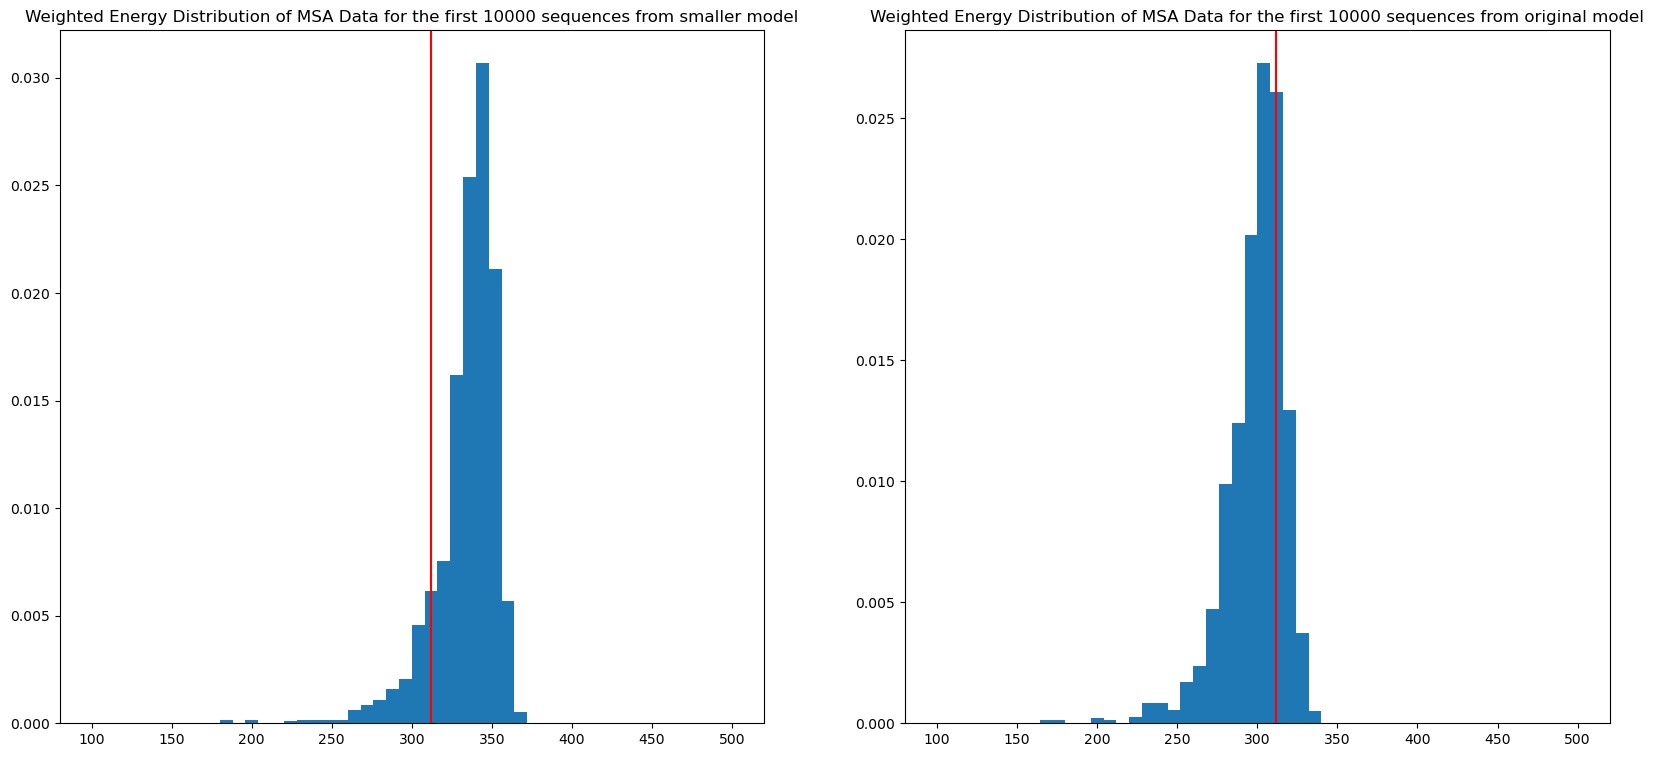

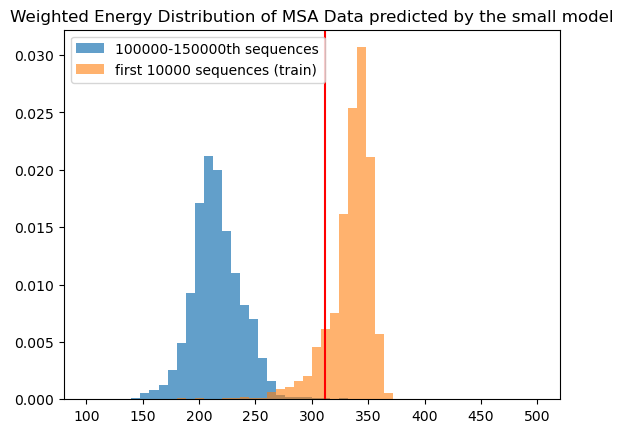

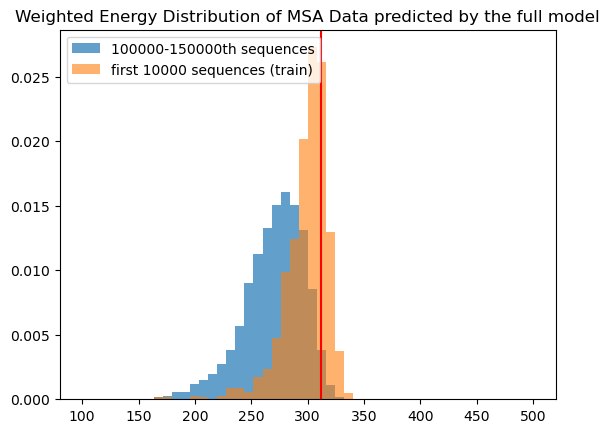

In [72]:
analyze_smaller_model(10000, 100000, 150000)

Number of sites:  82
Number of valid sequences:  19935
Number of invalid sequences:  65
Number of valid sequences:  19935


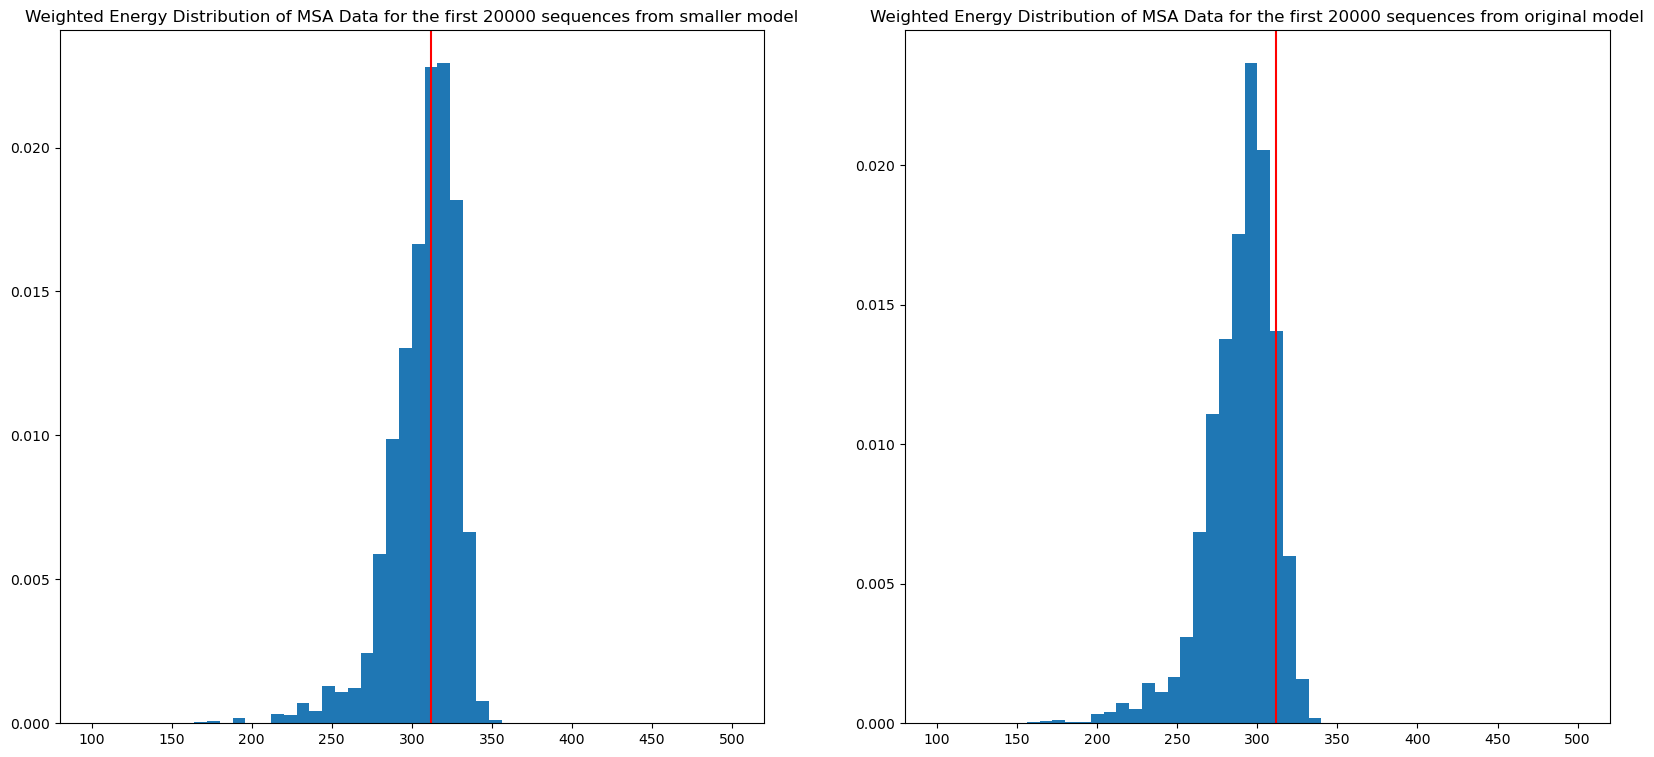

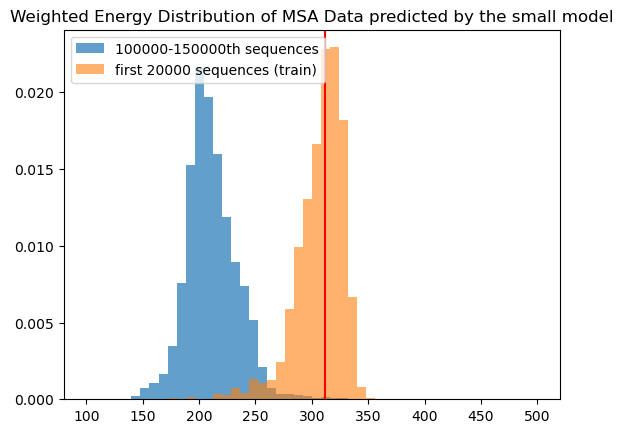

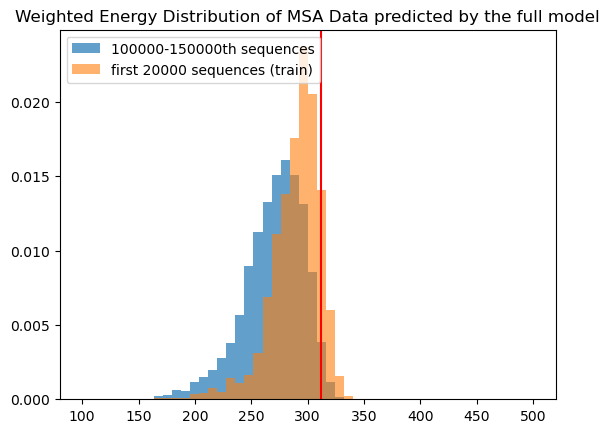

In [73]:
analyze_smaller_model(20000, 100000, 150000)

Number of sites:  82
Number of valid sequences:  39887
Number of invalid sequences:  113
Number of valid sequences:  39887


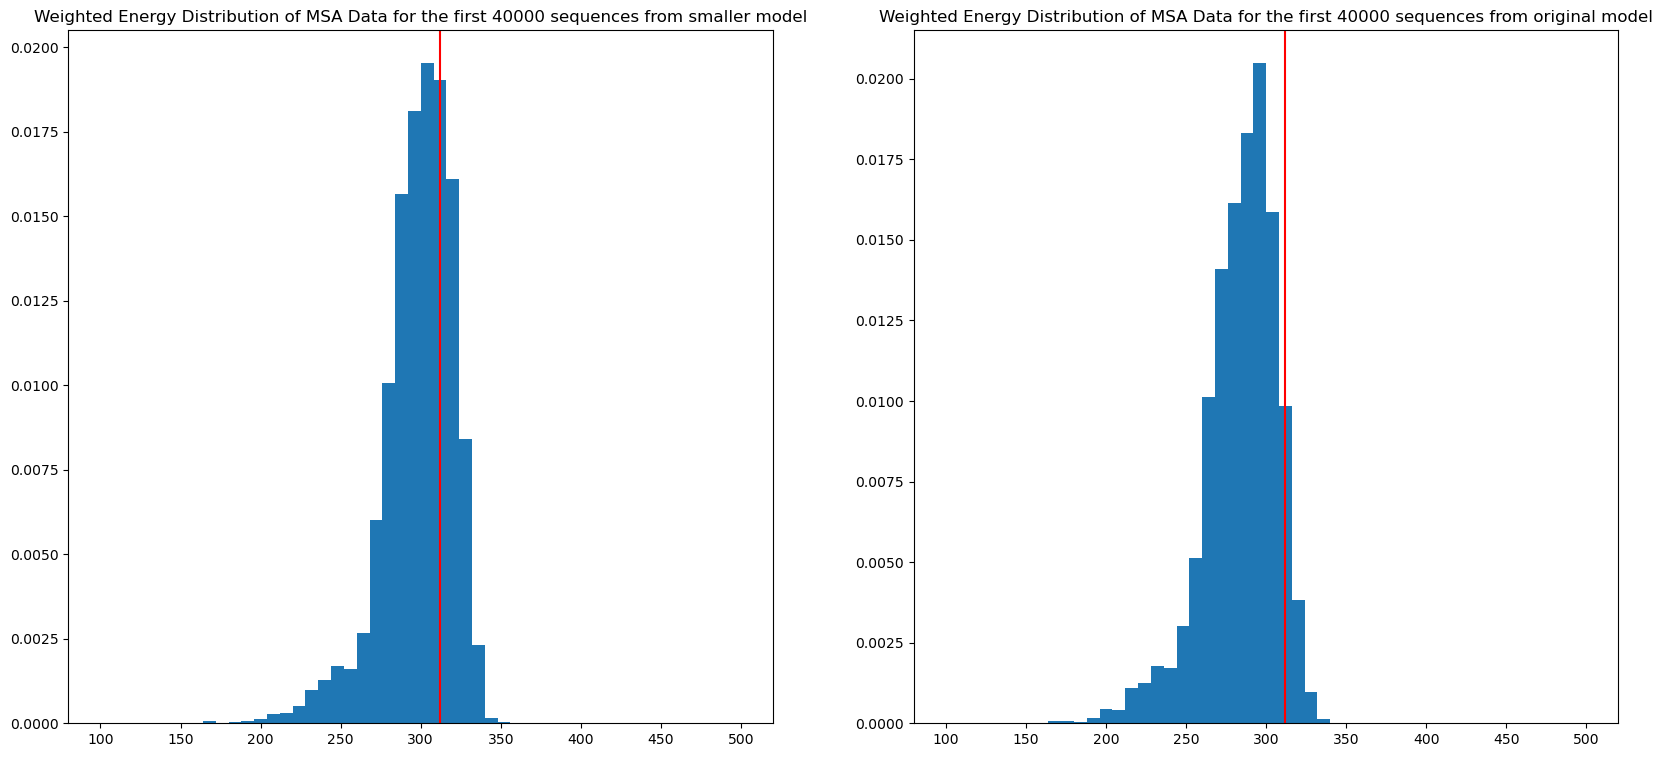

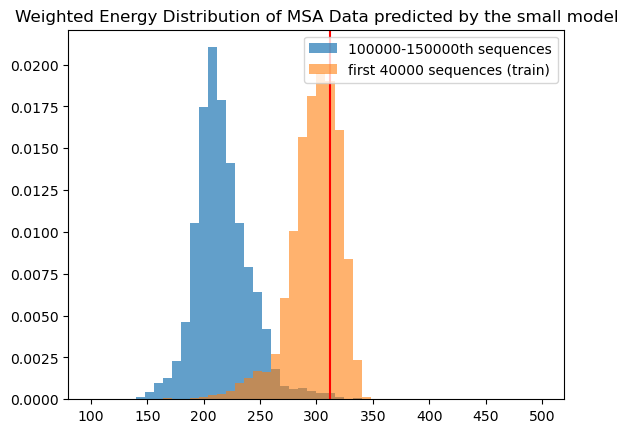

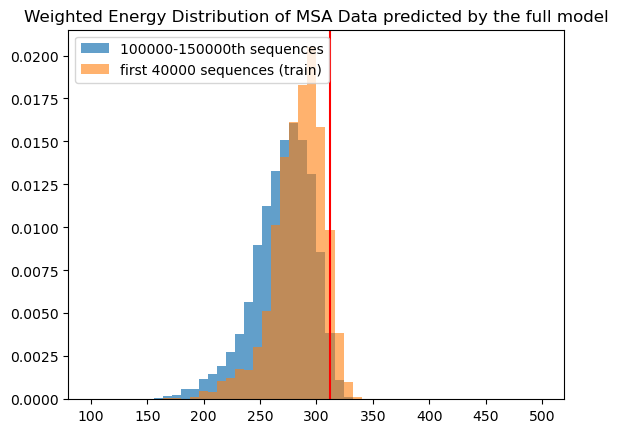

In [10]:
analyze_smaller_model(40000, 100000, 150000)

Number of sites:  82
Number of valid sequences:  99663
Number of invalid sequences:  337
Number of valid sequences:  99663


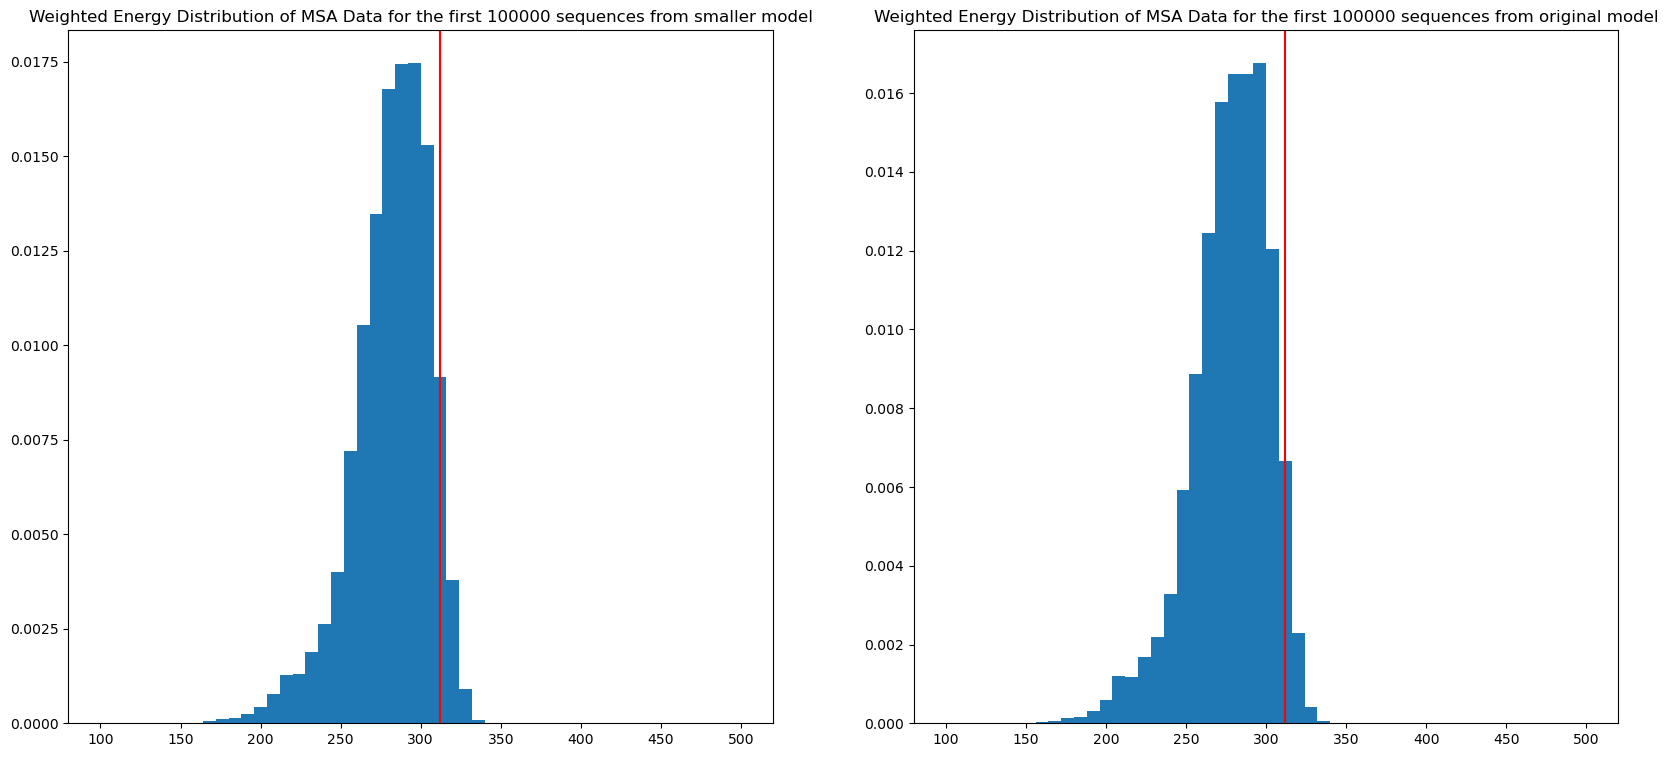

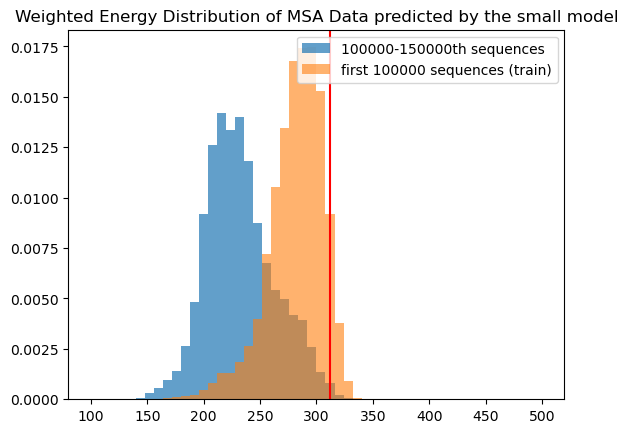

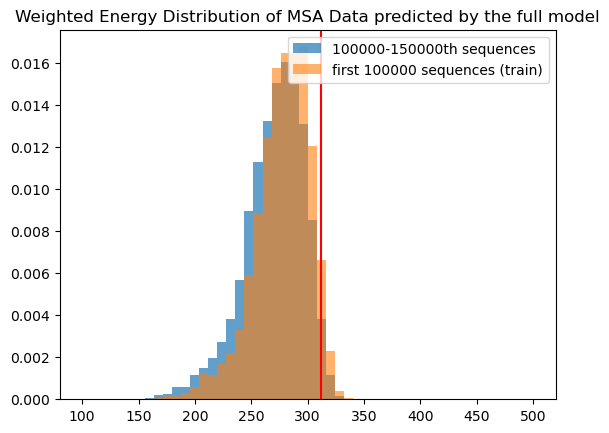

In [11]:
analyze_smaller_model(100000, 100000, 150000)